### Classification 101 - Using the Titanic dataset
The Titanic dataset is often used to demonstrate classification problems and in particular to predict if someone with certain characteristics (e.g. age, gender, class), survived the sinking of the Titanic. More information can be found on https://www.kaggle.com/c/titanic, with the data dictionary being located at https://www.kaggle.com/c/titanic/data.

Classification problems are usually scored using a Confusion Matrix and the Accuracy, Precision, Recall, AUC, calculated from it. More details can be found at https://en.wikipedia.org/wiki/Confusion_matrix and a few helpful equations are displayed below:

* TP...True Positives
* TN...True Negatives
* FP...A negative falsely classified as positive - Type I error
* FN...A positive falsely classified as negative - Type 2 error

* Accuracy: (TP + TN) / All
* Precision: TP / (TP + FP) (how many predicted positives are actually positive)
* Recall: TP / (TP + FN) (how good the model is at finding the true positives)

In [1]:
#import standard packages
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime

#import sklearn/xgboost subpackages
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix)

#import other necessary packages
import missingno as msno # https://github.com/ResidentMario/missingno, not the Pokemon!
import eli5 # http://eli5.readthedocs.io/en/latest/overview.html
from eli5.sklearn import PermutationImportance
from IPython.display import display

In [2]:
# defining constants that will be used later on
SEED = 13
RANDOM_SEEDS = random.sample(range(1000),100)
TEST_SIZE = 0.3

In [3]:
#defining functions that will be used later on
def dummy_classifier(X, y, strategy):
    """Function to run all the training/test dataset splits 
    (defined by the RANDOM_SEEDS used for random_state) through 
    the Dummy Classifier and to calculate/plot the distribution 
    of the accuracy, recall, precision, AUC."""
    accuracy_list = []
    recall_list = []
    precision_list = []
    auc_list = []
    target_no_list = []
    for element in RANDOM_SEEDS:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=TEST_SIZE,
            random_state=element)

        model = DummyClassifier(strategy=strategy)
        model.fit(X_train, y_train.values.ravel())

        accuracy = accuracy_score(y_test, model.predict(X_test))
        recall = recall_score(y_test, model.predict(X_test))
        precision = precision_score(y_test, model.predict(X_test))
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        accuracy_list.append(accuracy)
        recall_list.append(recall)
        precision_list.append(precision)
        auc_list.append(auc)
        target_no_list.append(y_train.value_counts([0])[0])

    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10,7))
    plt.suptitle(strategy, fontsize=13)
    ax = axs[0,0]
    ax.hist(accuracy_list, bins = 10)
    ax.set_xlabel('Accuracy')
    ax = axs[0,1]
    ax.hist(recall_list,bins=10)
    ax.set_xlabel('Recall')
    ax = axs[1,0]
    ax.hist(precision_list, bins = 10)
    ax.set_xlabel('Precision')
    ax = axs[1,1]
    ax.hist(auc_list,bins=10);
    ax.set_xlabel('AUC');

    print('''The mean AUC for the baseline model is {0:.2f},
    therefore any model build has to perform better than
    this.'''.format(sum(auc_list)/len(auc_list)))

def normalised_confusion_matrix(y_true, y_pred, normalise = False):
    """Function to calculate normalised confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    if normalise:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    return cm

def accuracy_recall_precision_auc(model, X, y):
    """Output Accuracy, Recall, Precision, AUC, Confusion Matrix,
    false positive rate, true negative rate, and thresholds for the 
    ROC curve."""
    print('Accuracy: {0:.2f}%'.format(accuracy_score(
        y, model.predict(X))*100))
    print('Recall: {0:.2f}%'.format(recall_score(
        y, model.predict(X))*100))
    print('Precision: {0:.2f}%'.format(precision_score(
        y, model.predict(X))*100))
    print('AUC: {0:.2f}%'.format(roc_auc_score(
        y, model.predict_proba(X)[:,1])*100))
    print('Confusion Matrix:\n', 
           confusion_matrix(y, model.predict(X)))
    
    cm = normalised_confusion_matrix(
        y, model.predict(X), normalise=True)
    fp, tp, thresholds = roc_curve(
        y,model.predict_proba(X)[:,1])
    return fp, tp, thresholds, cm

def roc_plot(model, X_train, y_train, X_test, y_test, model_name):
    """Function to plot ROC curve from train and test dataset."""
    print('\nTrain:')
    fp_train, tp_train, thresholds_train, cm_train = accuracy_recall_precision_auc(
        model, X_train, y_train)
    print('\nTest:')
    fp_test, tp_test, thresholds_test, cm_test = accuracy_recall_precision_auc(
        model, X_test, y_test)
    
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=False)
    fig.set_size_inches(16, 4)
    plt.suptitle(model_name, fontsize=13)
    ax0.set_title('ROC Curve')
    ax0.plot([0, 1], [0, 1],'k--')
    ax0.plot(fp_train, tp_train, label='Train')
    ax0.plot(fp_test, tp_test, label='Test')
    ax0.set_xlim([0.0, 1.0])
    ax0.set_ylim([0.0, 1.0])   
    ax0.legend(loc='lower right')
    sns.heatmap(cm_train, annot=True, ax=ax1)
    ax1.set_title('Train Confusion Matrix')
    sns.heatmap(cm_test, annot=True, ax=ax2)
    ax2.set_title('Test Confusion Matrix');
    plt.show()
    
def different_models(input_model, X, y, model_name, xgboost=True):
    """Function to plot the histogram of Accuracy, Recall, Precision, 
    AUC for the number of random_states defined in RANDOM_SEEDS to get 
    a distribution of those values."""
    accuracy_list = []
    recall_list = []
    precision_list = []
    auc_list = []

    for element in RANDOM_SEEDS:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=TEST_SIZE, random_state=element)
        
        if xgboost == True:
            X_train_matrix = X_train.as_matrix()
            y_train_matrix = y_train.as_matrix()
            X_test_matrix = X_test.as_matrix()
            y_test_matrix = y_test.as_matrix()

            model = input_model
            model.fit(X_train_matrix, y_train_matrix)           
            
            accuracy = accuracy_score(
                y_test_matrix, model.predict(X_test_matrix))
            recall = recall_score(
                y_test_matrix, model.predict(X_test_matrix))
            precision = precision_score(
                y_test_matrix, model.predict(X_test_matrix))
            auc = roc_auc_score(
                y_test_matrix, model.predict_proba(X_test_matrix)[:,1])

            accuracy_list.append(accuracy)
            recall_list.append(recall)
            precision_list.append(precision)
            auc_list.append(auc)            
            
        else:
            model = input_model
            model.fit(X_train, y_train.values.ravel())
            
            accuracy = accuracy_score(
                y_test, model.predict(X_test))
            recall = recall_score(
                y_test, model.predict(X_test))
            precision = precision_score(
                y_test, model.predict(X_test))
            auc = roc_auc_score(
                y_test, model.predict_proba(X_test)[:,1])

            accuracy_list.append(accuracy)
            recall_list.append(recall)
            precision_list.append(precision)
            auc_list.append(auc)
    
    print('Permutation Importance:')
    if xgboost == True:
        perm = PermutationImportance(model).fit(
            X_test_matrix, y_test_matrix)
        display(eli5.show_weights(perm, 
                                  feature_names=list(X_train.columns))) 
    else:    
        perm = PermutationImportance(model).fit(X_test,y_test)
        display(eli5.show_weights(perm, 
                                  feature_names=list(X_train.columns)))
            
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9,6))
    fig.suptitle(model_name, fontsize=14)
    ax = axs[0,0]
    ax.hist(accuracy_list, bins = 10)
    ax.set_xlabel('Accuracy')
    ax = axs[0,1]
    ax.hist(recall_list,bins=10)
    ax.set_xlabel('Recall')
    ax = axs[1,0]
    ax.hist(precision_list, bins = 10)
    ax.set_xlabel('Precision')
    ax = axs[1,1]
    ax.hist(auc_list,bins=10);
    ax.set_xlabel('AUC');
    #print(pd.DataFrame(X_test.columns))
    print('''The mean {0} AUC for the model is {1:.2f}.'''.format(
        model_name, sum(auc_list)/len(auc_list)))
    return model

def model3seeds(model_input, X, y, model_name):
    """Function to print the ROC and Confusion Matrix for the SEEDS 
    defined below."""
    print(model_name)
    for element in [25,42,69]:
        print('==============================\nSEED =', element)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=TEST_SIZE, random_state=element)
        model = model_input
        model.fit(X_train, y_train.values.ravel())
        roc_plot(model, X_train, y_train, X_test, y_test, model_name)
    return model

The cell below reads in the data from the .csv file and analyses how many missing values each of the columns has. Columns with low fill rates are removed from the dataset as we only have 1309 rows, therefore should avoid deleting rows.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310 entries, 0 to 1309
Data columns (total 12 columns):
pclass      1309 non-null float64
survived    1309 non-null float64
sex         1309 non-null object
age         1046 non-null float64
sibsp       1309 non-null float64
parch       1309 non-null float64
ticket      1309 non-null object
fare        1308 non-null float64
cabin       295 non-null object
embarked    1307 non-null object
boat        486 non-null object
body        121 non-null float64
dtypes: float64(7), object(5)
memory usage: 122.9+ KB
None


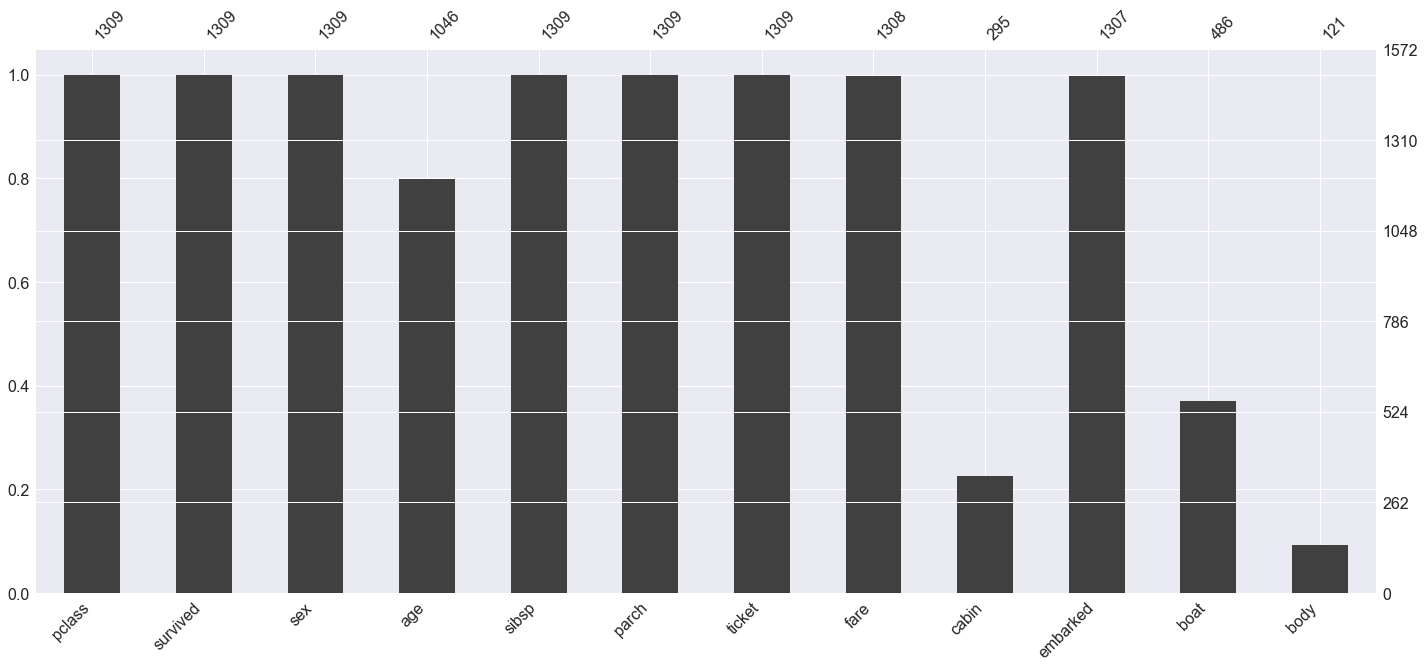

,pclass,survived,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body
0,1.0,1.0,female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN
1,1.0,1.0,male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN
2,1.0,0.0,female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN
3,1.0,0.0,male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,135.0
4,1.0,0.0,female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN


In [4]:
df = pd.read_csv('titanic.csv')
print(df.info())
msno.bar(df)
df.head()

The target variable for this problem set is _survived_. _body_, _cabin_, and _boat_ all have fillrates <40% and are high cardinality categorical variables, therefore I decided not to use them for model build. I also remove _ticket_ as it is the ticket number and also of high cardinality, even though the fillrate is very high.

I also remove the 1 row where _fare_ is _nan_ and the 3 rows where _embarked_ is _nan_. Then I check the distribution of the target variable _survived_ and if you have to consider class imbalance (i.e. when one of the 2 classes is far more common than the other. This becomes a problem in ML because e.g. if you have a dataset with 96% negative values and 4% positive values, the best model accuracy of 96% can be achieved by classifying all data as negative. While this leads to maximum Accuracy, it will have Precision & Recall of 0, and the AUC will be much lower (read more at e.g. https://www.kaggle.com/general/7517). This will not be a good model.


In [5]:
df.drop(['ticket','cabin','boat','body'], axis=1, inplace=True)
print('Columns:\n', df.columns.tolist())

df_nonull = df[(df['fare'].notnull()) & (df['embarked'].notnull())] 
print('Shape of new df:', df_nonull.shape)
print('\nDistribtion of target variable:\n', 
      df_nonull.survived.value_counts())

Columns:
 ['pclass', 'survived', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
Shape of new df: (1306, 8)

Distribtion of target variable:
 0.0    808
1.0    498
Name: survived, dtype: int64


There is a slight class imbalance, therefore I will need to consider this during model build, e.g. by setting scale_pos_weight in XGBClassifier or class_weight in other tree algorithms. I use tree algorithms here, as the preprocessing is much easier than for Logistic Regression and the results are usually better.

The next step is to split __categorical__ and continous variables as these need different preprocessing before model build. Categorical variables are low maintenance for tree algorithms, all I have to do is LabelEncode them (http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html). 

Side Note: For Logistic Regression you need to OneHotEncode the variables (http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) which can lead to one column being represented by many 0/1 columns, leading to the curse of dimensionality.

__Continuous__ variables are also easier to prepare for tree algorithms, as they can be taken at face value (if you are not using XGBClassifier, but one of the other algorithms, you will have to impute the missing values, but XGBClassifier can handle NULL values), while for Logistic Regression they have to be scaled depending on what distribution they follow. In this dataset the only continuous variable with missing values is _age_, therefore I will impute the median age where there is no entry.

Categorical Columns ['sex', 'embarked'] 
Continuous Columns: ['pclass', 'age', 'sibsp', 'parch', 'fare']

Number of entries in each category.

 sex
male      842
female    464
Name: sex, dtype: int64

 embarked
S    913
C    270
Q    123
Name: embarked, dtype: int64
Median age in dataset: 28.0


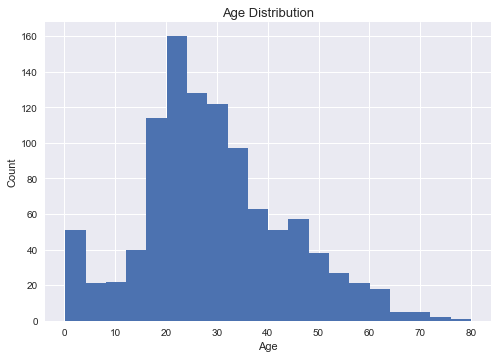

In [6]:
X_cat = df_nonull.drop(
    'survived', axis=1).select_dtypes(include=['object'])
X_cont = df_nonull.drop(
    'survived', axis=1).select_dtypes(include=['float64'])
print('Categorical Columns', X_cat.columns.tolist(),
      '\nContinuous Columns:', X_cont.columns.tolist())

#categorical variables
print('\nNumber of entries in each category.')
for col in X_cat.columns:
    print('\n',col)
    print(X_cat[col].value_counts())
    
le = LabelEncoder()
X_cat['sex_enc'] = le.fit_transform(X_cat.sex)
X_cat['embarked_enc'] = le.fit_transform(X_cat.embarked)
X_cat.drop(['sex','embarked'], axis=1, inplace=True)

#continuous variables 
plt.hist(X_cont.age[X_cont.age.notnull() == True], bins = 20);
plt.title('Age Distribution', fontsize=13)
plt.xlabel('Age')
plt.ylabel('Count')

#Impute median age where age is NULL
X_cont.loc[X_cont.age.isnull(), 'age']  = X_cont.age.median()
print('Median age in dataset:', X_cont.age.median())    

X = X_cat.merge(X_cont, left_index=True, right_index=True)
y = df_nonull['survived']

=========================================================================
### Baseline Model Build
Now that the preprocessing is done I build a baseline model with *DummyClassifier* (http://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) to determine what AUC a ML model needs to beat, to be better than random.

The mean AUC for the baseline model is 0.50,
    therefore any model build has to perform better than
    this.


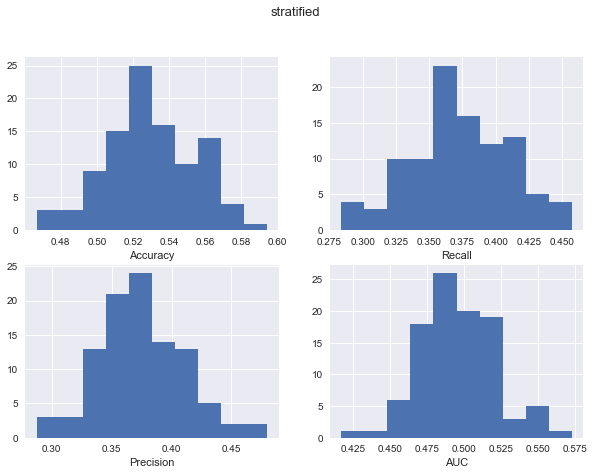

In [7]:
#Dummy classifier that compensates for class imbalance
dummy_classifier(X,y,'stratified')

//anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


The mean AUC for the baseline model is 0.50,
    therefore any model build has to perform better than
    this.


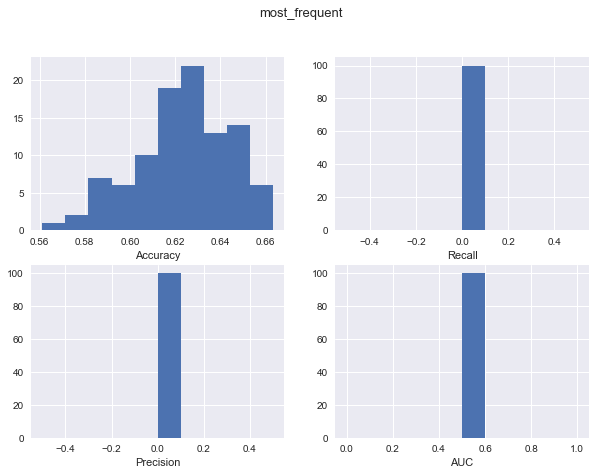

In [8]:
#Dummy classifier that always selects the most frequent class
dummy_classifier(X,y,'most_frequent')

As shown above, the 'most_frequent' model never predicts 1 as it is the lower frequency class, therefore Precision and Recall will be 0 (hence the warning).

========================================================================

### Untuned Tree Algorithms
Below I run several untuned tree algorithms to see which one performs best and if it can outperform the baseline model (if it cannot, there is no point in building a model in the first place).

I also analyse feature importance in an attempt to sanity check the model. Permutation importance measures feature importance by looking at how much the score (accuracy, F1, R^2, etc.) decreases when a feature is not available (http://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html). When you delevop models for non-technical stakeholder, I highly recommend using this to help them understand how the model works. 

#### Untuned XGBClassifier

XGBClassifier
SEED = 25

Train:
Accuracy: 86.11%
Recall: 75.14%
Precision: 87.21%
AUC: 92.71%
Confusion Matrix:
 [[521  39]
 [ 88 266]]

Test:
Accuracy: 79.59%
Recall: 63.89%
Precision: 76.67%
AUC: 84.26%
Confusion Matrix:
 [[220  28]
 [ 52  92]]


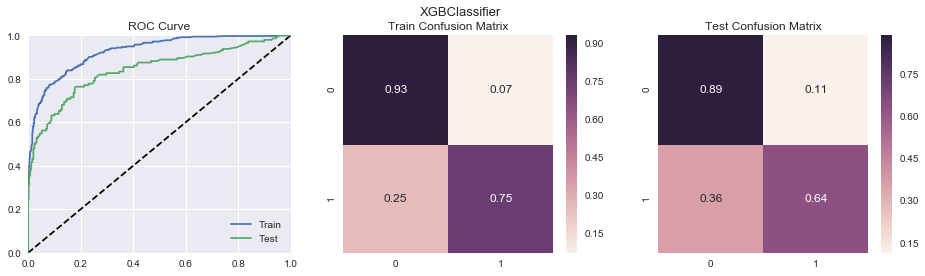

SEED = 42

Train:
Accuracy: 85.56%
Recall: 72.46%
Precision: 87.11%
AUC: 92.31%
Confusion Matrix:
 [[532  37]
 [ 95 250]]

Test:
Accuracy: 79.08%
Recall: 67.32%
Precision: 76.30%
AUC: 85.01%
Confusion Matrix:
 [[207  32]
 [ 50 103]]


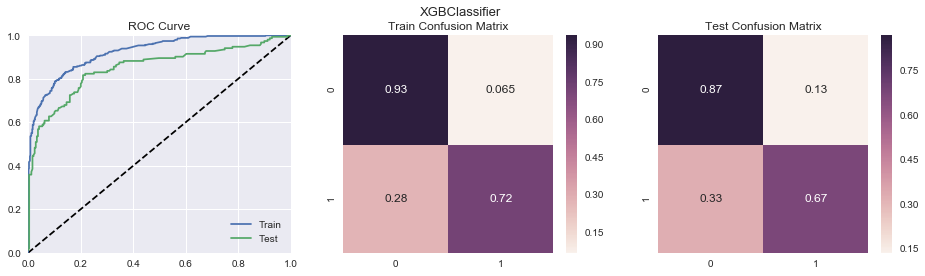

SEED = 69

Train:
Accuracy: 85.12%
Recall: 70.14%
Precision: 88.00%
AUC: 92.14%
Confusion Matrix:
 [[536  33]
 [103 242]]

Test:
Accuracy: 81.63%
Recall: 69.28%
Precision: 80.92%
AUC: 87.99%
Confusion Matrix:
 [[214  25]
 [ 47 106]]


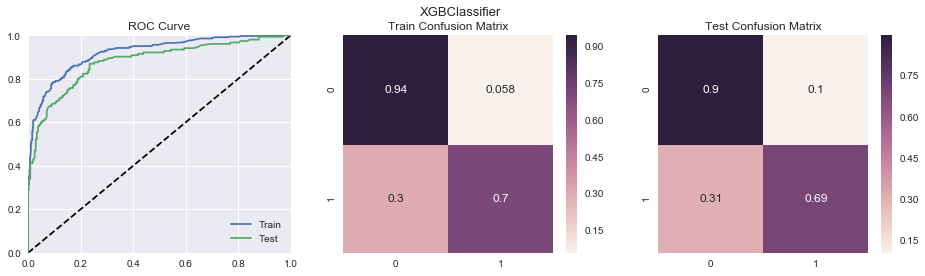

Permutation Importance:


Weight,Feature
0.2138 ± 0.0231,sex_enc
0.0974 ± 0.0122,pclass
0.0337 ± 0.0358,age
0.0122 ± 0.0293,fare
0.0082 ± 0.0088,sibsp
0.0071 ± 0.0068,embarked_enc
0.0005 ± 0.0038,parch


The mean XGBClassifier AUC for the model is 0.86.


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

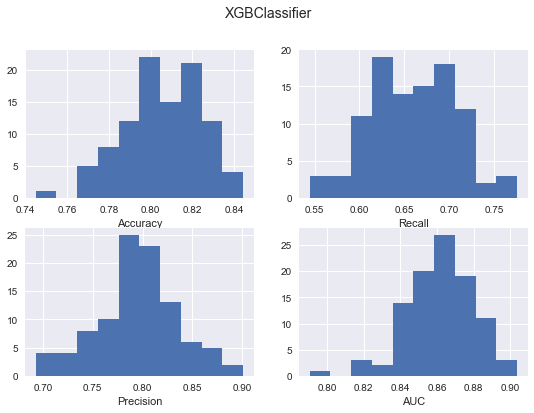

In [9]:
model3seeds(XGBClassifier(), X, y, 'XGBClassifier')
different_models(XGBClassifier(), X, y, 'XGBClassifier', xgboost=True)

#### Untuned RandomForestClassifier

RandomForestClassifier
SEED = 25

Train:
Accuracy: 95.08%
Recall: 91.81%
Precision: 95.31%
AUC: 99.25%
Confusion Matrix:
 [[544  16]
 [ 29 325]]

Test:
Accuracy: 78.57%
Recall: 69.44%
Precision: 71.43%
AUC: 85.81%
Confusion Matrix:
 [[208  40]
 [ 44 100]]


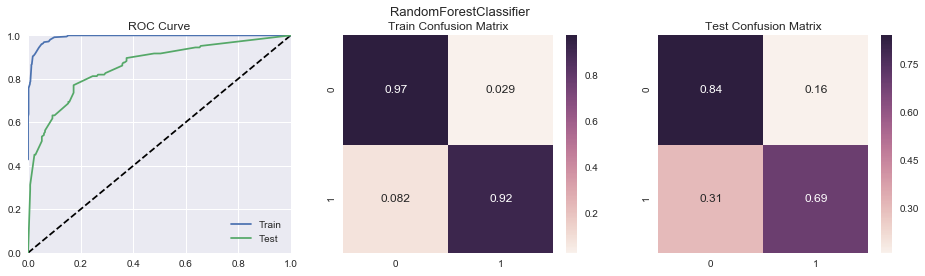

SEED = 42

Train:
Accuracy: 96.17%
Recall: 92.75%
Precision: 96.97%
AUC: 99.40%
Confusion Matrix:
 [[559  10]
 [ 25 320]]

Test:
Accuracy: 76.53%
Recall: 68.63%
Precision: 70.47%
AUC: 82.67%
Confusion Matrix:
 [[195  44]
 [ 48 105]]


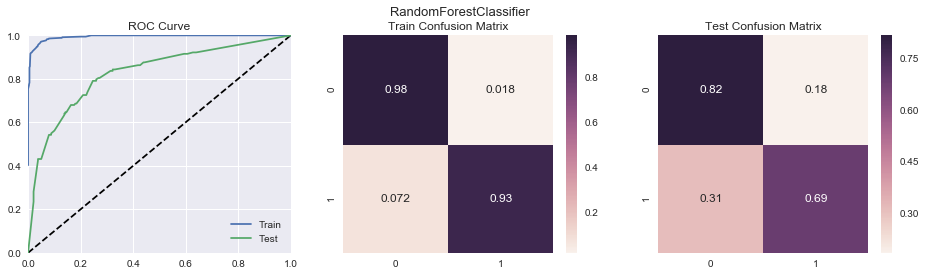

SEED = 69

Train:
Accuracy: 95.30%
Recall: 92.17%
Precision: 95.21%
AUC: 98.92%
Confusion Matrix:
 [[553  16]
 [ 27 318]]

Test:
Accuracy: 79.59%
Recall: 71.90%
Precision: 74.83%
AUC: 83.95%
Confusion Matrix:
 [[202  37]
 [ 43 110]]


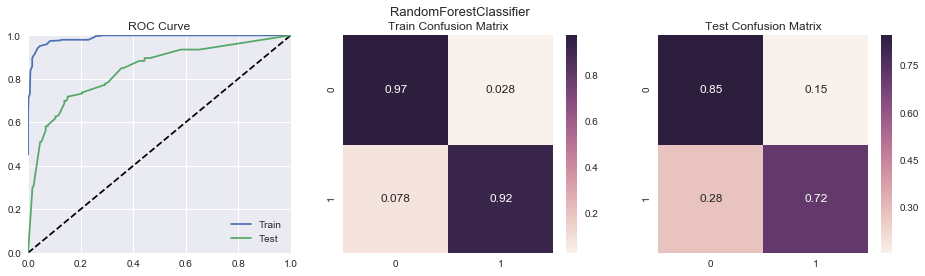

Permutation Importance:


Weight,Feature
0.1485 ± 0.0197,sex_enc
0.0617 ± 0.0114,pclass
0.0240 ± 0.0100,fare
0.0117 ± 0.0153,sibsp
0.0102 ± 0.0133,parch
0.0066 ± 0.0230,age
0.0000 ± 0.0151,embarked_enc


The mean RandomForestClassifier AUC for the model is 0.83.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

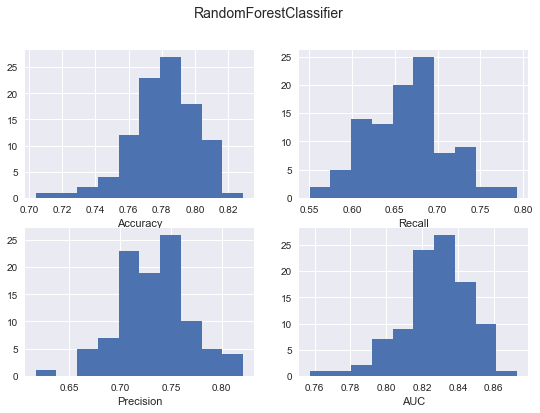

In [10]:
model3seeds(RandomForestClassifier(), 
            X, y, 'RandomForestClassifier')
different_models(RandomForestClassifier(), 
                 X, y, 'RandomForestClassifier', xgboost=False)

#### ExtraTreeClassifier

ExtraTreeClassifier
SEED = 25

Train:
Accuracy: 96.72%
Recall: 92.94%
Precision: 98.50%
AUC: 99.75%
Confusion Matrix:
 [[555   5]
 [ 25 329]]

Test:
Accuracy: 76.28%
Recall: 70.83%
Precision: 66.67%
AUC: 76.05%
Confusion Matrix:
 [[197  51]
 [ 42 102]]


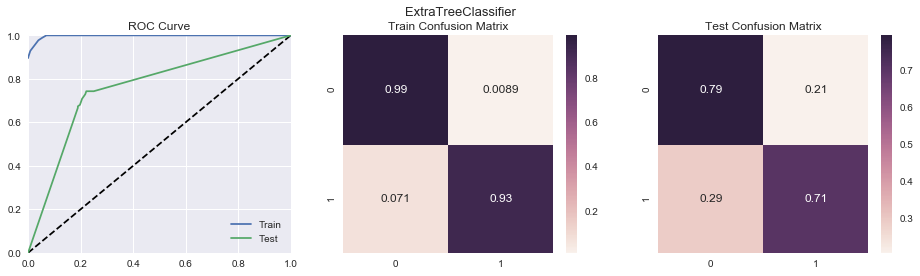

SEED = 42

Train:
Accuracy: 97.37%
Recall: 94.20%
Precision: 98.78%
AUC: 99.84%
Confusion Matrix:
 [[565   4]
 [ 20 325]]

Test:
Accuracy: 76.28%
Recall: 69.93%
Precision: 69.48%
AUC: 76.72%
Confusion Matrix:
 [[192  47]
 [ 46 107]]


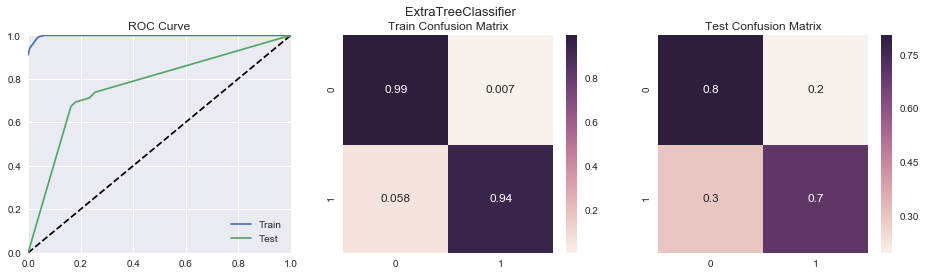

SEED = 69

Train:
Accuracy: 96.28%
Recall: 92.17%
Precision: 97.85%
AUC: 99.67%
Confusion Matrix:
 [[562   7]
 [ 27 318]]

Test:
Accuracy: 76.02%
Recall: 71.24%
Precision: 68.55%
AUC: 75.70%
Confusion Matrix:
 [[189  50]
 [ 44 109]]


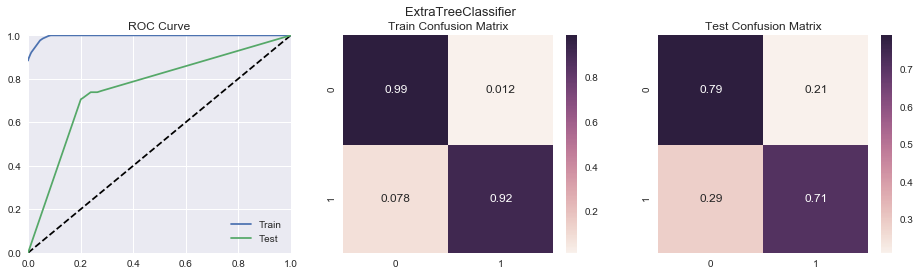

Permutation Importance:


Weight,Feature
0.1515 ± 0.0247,sex_enc
0.1000 ± 0.0361,pclass
0.0240 ± 0.0211,parch
0.0204 ± 0.0315,age
0.0163 ± 0.0220,fare
0.0112 ± 0.0234,embarked_enc
-0.0082 ± 0.0131,sibsp


The mean ExtraTreeClassifier AUC for the model is 0.74.


ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          random_state=None, splitter='random')

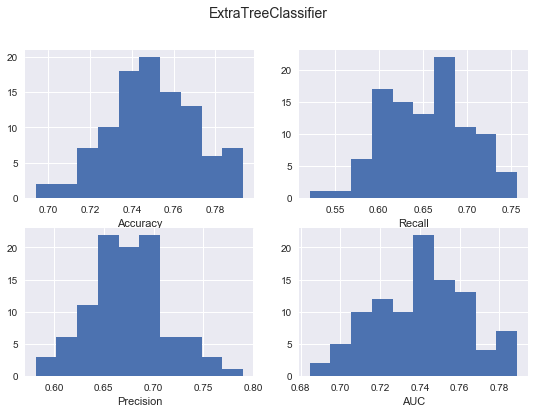

In [11]:
model3seeds(ExtraTreeClassifier(), 
            X, y, 'ExtraTreeClassifier')
different_models(ExtraTreeClassifier(), 
                 X, y, 'ExtraTreeClassifier', xgboost=False)

All the above tree algorithms overfit the training data, as can be seen by the training AUC being much higher than the testing AUC. This can be compensated for by setting the max_depth in the model to a smaller value or by tuning several other parameters. 

When I look at the AUC histogram plots, I see that, while overtuned, the XGBClassifier performs best, therefore I will continue using it as the model for this dataset. I am tuning it below using RandomizedSearchCV (http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). This is quicker than GridSearchCV (http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) as it randomly choses _niter_ number of combinations from the parameter space and finds the best one. I also tune on roc_auc score and neg_log_loss.

========================================================================

### Tuning XGBClassifier

#### Tuning parameters:
See https://github.com/dmlc/xgboost/blob/master/doc/parameter.md for more details.

* **learning_rate** (default: 0.3, range:(0,1]): step size to prevent overfitting
* **n_elements** (default: 100, range:(0,1]): number of trees to build
* **gamma** (default:0, range: [0,∞]): minimum loss reduction required to make further partition on leaf node - The larger, the more conservative the algorithm.
* **max_depth** (default=6, range: [0,∞]): maximum depth of tree, the greater the depth, the more complex the model, constrain to avoid overfitting.
* **min_child_weight** (default=1, range: [0,∞]): minimum sum of leaf node weights needed in a child, the larger, the more conservative the algorithm is.
* **subsample** (default=1, range: (0,1]): subsample ratio of the training instances used. To prevent overfitting it should be lowered.
* **colsample_bytree** (default=1, range: (0,1]): subsample ratio of columns when constructing each tree.
* **colsample_bylevel** (default=1, range: (0,1]): subsample ratio of columns for each split, in each level.
* **reg_lambda** (default=1): L2 regularization term on weights, increasing this value will make the model more conservative.
* **reg_alpha** (default=0): L1 regularization term on weights, increasing this value will make the model more conservative.
* **scale_pos_weight** (default=1): controls the balance of positive and negative weights, useful for unbalanced classes. A typical value to consider: sum(negative cases) / sum(positive cases).

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=SEED)

print('Shape of X_train {0}, y_train {1} and X_test {2}, y_test {3}.'.format(
    X_train.shape, y_train.shape, X_test.shape, y_test.shape))

Shape of X_train (914, 7), y_train (914,) and X_test (392, 7), y_test (392,).


------------------------------------------------------------------------

#### ROC/AUC Tuning

In [13]:
SCORING = 'roc_auc'

param_test = {'colsample_bytree':[i/10.0 for i in range(2,11)],
              'gamma':[i/10.0 for i in range(3,11)],
              'learning_rate':np.arange(0.0,0.5,0.05),
              'max_depth': np.arange(1,8,1),
              'min_child_weight': np.arange(1,5,1),
              'n_estimators': [80, 90, 100, 110, 120, 130, 140, 150],
              'scale_pos_weight': [0.5, 1, 1.5, 1.75, 2.0, 2.25, 2.5],
              'subsample':[i/10.0 for i in range(2,11)],
              'reg_lambda': [0, 0.5, 1],
              'reg_alpha': [0, 0.5, 1]}

xgb = XGBClassifier(silent=True)

rsearch_roc_auc = RandomizedSearchCV(xgb,
                             param_test,
                             n_jobs=-1,
                             scoring=SCORING,
                             n_iter=700,
                             cv=5)

rsearch_roc_auc.fit(X_train,y_train)

print('\nBest Paramters:\n', rsearch_roc_auc.best_params_, 
      '\n\nBest Tuning Score:', rsearch_roc_auc.best_score_)


Best Paramters:
 {'subsample': 0.9, 'scale_pos_weight': 1, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 80, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.10000000000000001, 'gamma': 0.8, 'colsample_bytree': 0.9} 

Best Tuning Score: 0.883113249631


XGBClassifier
SEED = 25

Train:
Accuracy: 84.03%
Recall: 73.45%
Precision: 83.33%
AUC: 91.42%
Confusion Matrix:
 [[508  52]
 [ 94 260]]

Test:
Accuracy: 79.59%
Recall: 64.58%
Precision: 76.23%
AUC: 84.79%
Confusion Matrix:
 [[219  29]
 [ 51  93]]


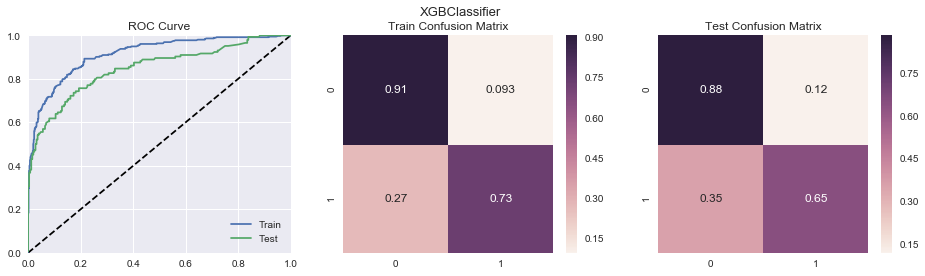

SEED = 42

Train:
Accuracy: 84.79%
Recall: 72.46%
Precision: 85.03%
AUC: 91.57%
Confusion Matrix:
 [[525  44]
 [ 95 250]]

Test:
Accuracy: 79.34%
Recall: 69.28%
Precision: 75.71%
AUC: 85.40%
Confusion Matrix:
 [[205  34]
 [ 47 106]]


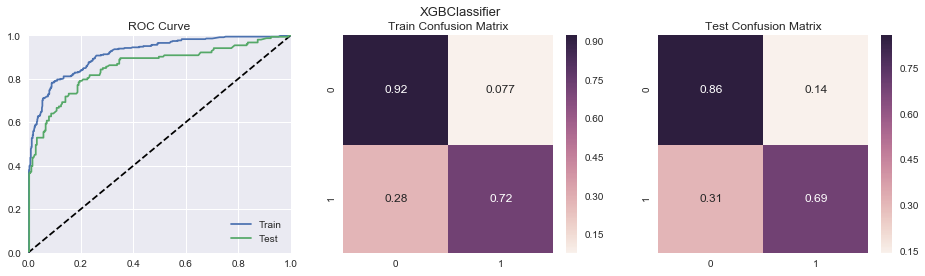

SEED = 69

Train:
Accuracy: 84.25%
Recall: 69.86%
Precision: 85.77%
AUC: 90.47%
Confusion Matrix:
 [[529  40]
 [104 241]]

Test:
Accuracy: 82.14%
Recall: 68.63%
Precision: 82.68%
AUC: 88.15%
Confusion Matrix:
 [[217  22]
 [ 48 105]]


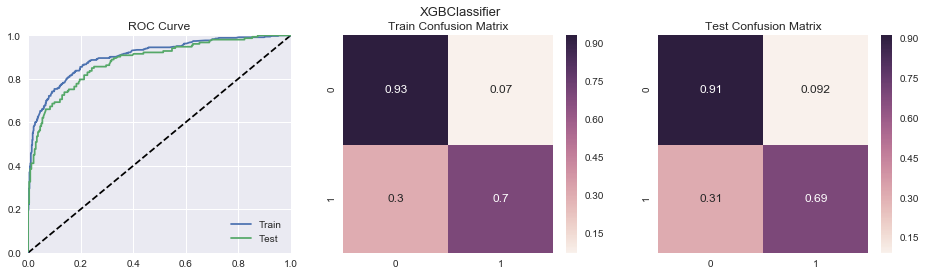

Permutation Importance:


Weight,Feature
0.2061 ± 0.0541,sex_enc
0.0719 ± 0.0181,pclass
0.0398 ± 0.0200,age
0.0128 ± 0.0072,sibsp
0.0051 ± 0.0032,fare
0.0020 ± 0.0038,parch
0.0020 ± 0.0094,embarked_enc


The mean XGBClassifier AUC for the model is 0.86.


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0.8, learning_rate=0.10000000000000001, max_delta_step=0,
       max_depth=3, min_child_weight=3, missing=None, n_estimators=80,
       nthread=-1, objective='binary:logistic', reg_alpha=0,
       reg_lambda=0.5, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9)

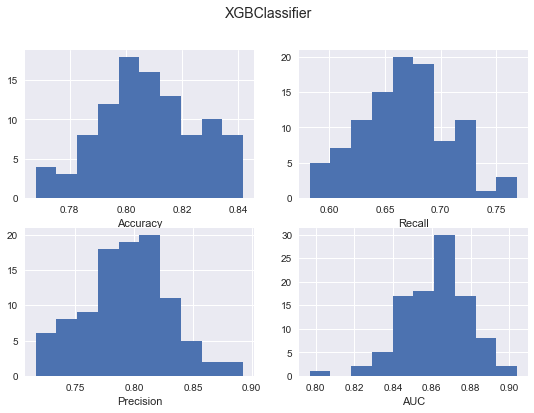

In [14]:
model3seeds(XGBClassifier(**rsearch_roc_auc.best_params_), 
            X, y, 'XGBClassifier')

different_models(XGBClassifier(**rsearch_roc_auc.best_params_), 
                 X, y, 'XGBClassifier', xgboost=True)

------------------------------------------------------------------------

#### Neg Log Loss Tuning

In [15]:
SCORING = 'neg_log_loss'

param_test = {'colsample_bytree':[i/10.0 for i in range(2,11)],
              'gamma':[i/10.0 for i in range(3,11)],
              'learning_rate':np.arange(0.0,0.5,0.05),
              'max_depth': np.arange(1,8,1),
              'min_child_weight': np.arange(1,5,1),
              'n_estimators': [80, 90, 100, 110, 120, 130, 140, 150],
              'scale_pos_weight': [0.5, 1, 1.5, 1.75, 2.0, 2.25, 2.5],
              'subsample':[i/10.0 for i in range(2,11)],
              'reg_lambda': [0, 0.5, 1],
              'reg_alpha': [0, 0.5, 1]}

xgb = XGBClassifier(silent=True)

rsearch_neg_log_loss = RandomizedSearchCV(xgb, 
                             param_test,
                             n_jobs=-1,
                             scoring=SCORING,
                             n_iter=700,
                             cv=5)

rsearch_neg_log_loss.fit(X_train,y_train)

print('\nBest Paramters:\n', rsearch_neg_log_loss.best_params_, 
      '\n\nBest Tuning Score:', rsearch_neg_log_loss.best_score_)


Best Paramters:
 {'subsample': 1.0, 'scale_pos_weight': 1, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 100, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.050000000000000003, 'gamma': 0.3, 'colsample_bytree': 0.9} 

Best Tuning Score: -0.403668940648


XGBClassifier
SEED = 25

Train:
Accuracy: 84.68%
Recall: 74.01%
Precision: 84.52%
AUC: 91.24%
Confusion Matrix:
 [[512  48]
 [ 92 262]]

Test:
Accuracy: 81.38%
Recall: 66.67%
Precision: 79.34%
AUC: 84.11%
Confusion Matrix:
 [[223  25]
 [ 48  96]]


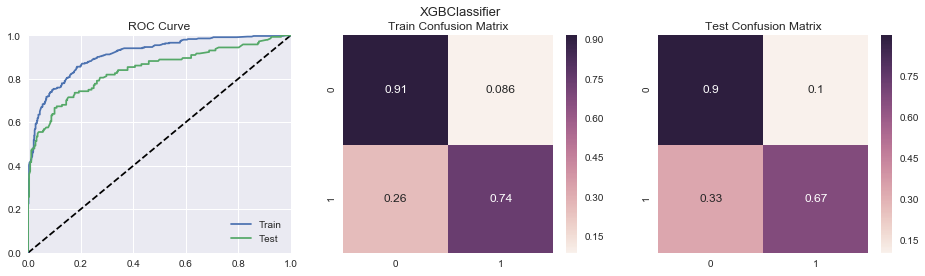

SEED = 42

Train:
Accuracy: 84.90%
Recall: 71.30%
Precision: 86.32%
AUC: 91.54%
Confusion Matrix:
 [[530  39]
 [ 99 246]]

Test:
Accuracy: 79.85%
Recall: 66.67%
Precision: 78.46%
AUC: 84.51%
Confusion Matrix:
 [[211  28]
 [ 51 102]]


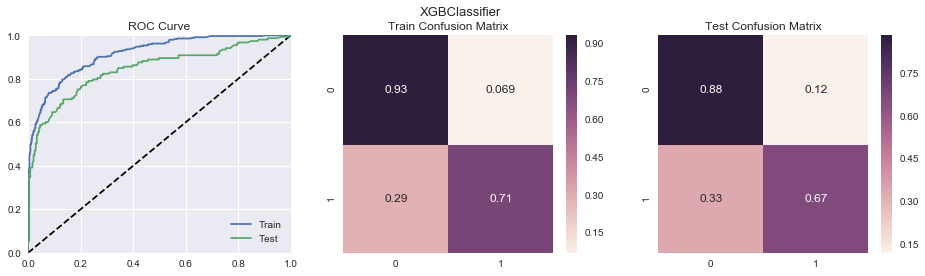

SEED = 69

Train:
Accuracy: 84.14%
Recall: 69.86%
Precision: 85.46%
AUC: 90.91%
Confusion Matrix:
 [[528  41]
 [104 241]]

Test:
Accuracy: 81.12%
Recall: 67.32%
Precision: 81.10%
AUC: 87.41%
Confusion Matrix:
 [[215  24]
 [ 50 103]]


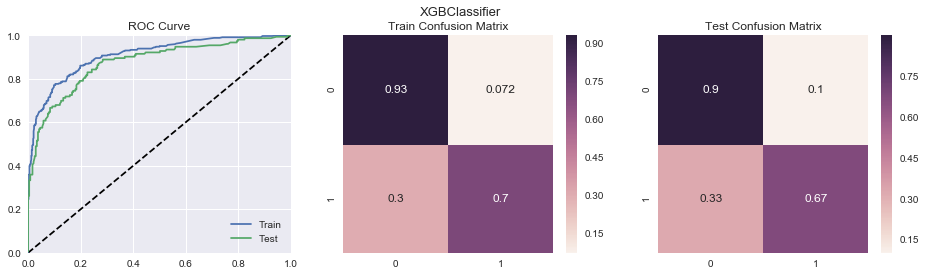

Permutation Importance:


Weight,Feature
0.1888 ± 0.0537,sex_enc
0.0878 ± 0.0131,pclass
0.0286 ± 0.0236,age
0.0158 ± 0.0175,fare
0.0051 ± 0.0107,sibsp
0.0020 ± 0.0020,parch
-0.0010 ± 0.0069,embarked_enc


The mean XGBClassifier AUC for the model is 0.86.


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0.3, learning_rate=0.050000000000000003, max_delta_step=0,
       max_depth=4, min_child_weight=2, missing=None, n_estimators=100,
       nthread=-1, objective='binary:logistic', reg_alpha=1, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1.0)

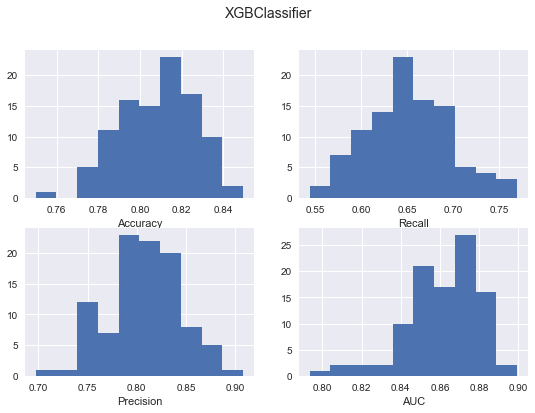

In [16]:
model3seeds(XGBClassifier(**rsearch_neg_log_loss.best_params_), 
            X, y, 'XGBClassifier')

different_models(XGBClassifier(**rsearch_neg_log_loss.best_params_), 
                 X, y, 'XGBClassifier', xgboost=True)

Both, tuning on roc_auc and on neg_log_loss, results in overfitting, therefore I will have to make the algorithm more conservative, so it generalises better to data it hasn't seen yet.

=========================================================================
### Remove overfitting

I continue with the roc_auc tuning below by constraining the parameter space to make the algorithm more conservative and reduce overfitting. While this may lead to a slight drop in AUC, it does make the whole model more robust and generalised.

In [17]:
SCORING = 'roc_auc'

param_test = {'colsample_bytree':[i/10.0 for i in range(2,11)],
              'gamma':[i/10.0 for i in range(7,11)],
              'learning_rate':np.arange(0.0,1.0,0.1),
              'max_depth': np.arange(1,3,1),
              'min_child_weight': np.arange(1,5,1),
              'n_estimators': [80, 90, 100, 110, 120, 130],
              'scale_pos_weight': [0, 0.5, 1.0],
              'subsample':[i/10.0 for i in range(2,8)],
              'reg_lambda': [0.5, 1],
              'reg_alpha': [0.5, 1]}

xgb = XGBClassifier(silent=True)

rsearch = RandomizedSearchCV(xgb, 
                             param_test,
                             n_jobs=-1,
                             scoring=SCORING,
                             n_iter=500,
                             cv=3)

rsearch.fit(X_train,y_train)

print('\nBest Paramters:\n', rsearch.best_params_, 
      '\n\nBest Tuning Score:', rsearch.best_score_)


Best Paramters:
 {'subsample': 0.7, 'scale_pos_weight': 1.0, 'reg_lambda': 1, 'reg_alpha': 0.5, 'n_estimators': 120, 'min_child_weight': 2, 'max_depth': 2, 'learning_rate': 0.20000000000000001, 'gamma': 0.8, 'colsample_bytree': 0.8} 

Best Tuning Score: 0.880143029638


XGBClassifier
SEED = 25

Train:
Accuracy: 84.57%
Recall: 72.32%
Precision: 85.62%
AUC: 91.31%
Confusion Matrix:
 [[517  43]
 [ 98 256]]

Test:
Accuracy: 80.36%
Recall: 66.67%
Precision: 76.80%
AUC: 85.01%
Confusion Matrix:
 [[219  29]
 [ 48  96]]


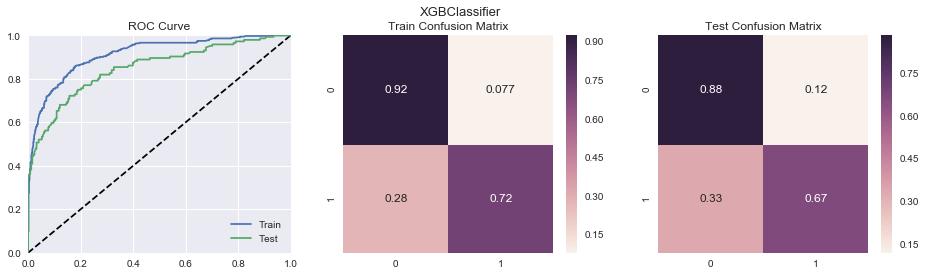

SEED = 42

Train:
Accuracy: 85.12%
Recall: 72.75%
Precision: 85.67%
AUC: 91.61%
Confusion Matrix:
 [[527  42]
 [ 94 251]]

Test:
Accuracy: 79.85%
Recall: 68.63%
Precision: 77.21%
AUC: 84.85%
Confusion Matrix:
 [[208  31]
 [ 48 105]]


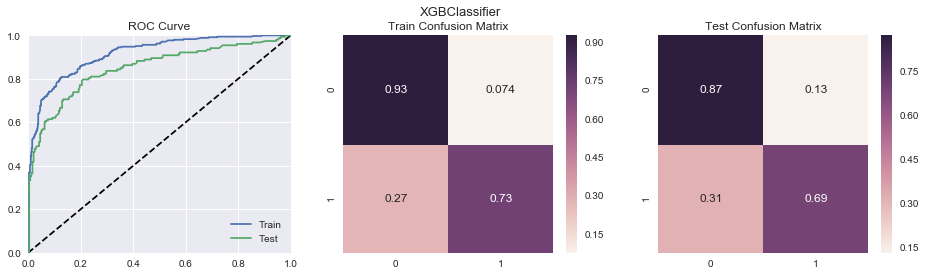

SEED = 69

Train:
Accuracy: 84.79%
Recall: 71.01%
Precision: 86.27%
AUC: 90.27%
Confusion Matrix:
 [[530  39]
 [100 245]]

Test:
Accuracy: 81.63%
Recall: 71.90%
Precision: 79.14%
AUC: 87.86%
Confusion Matrix:
 [[210  29]
 [ 43 110]]


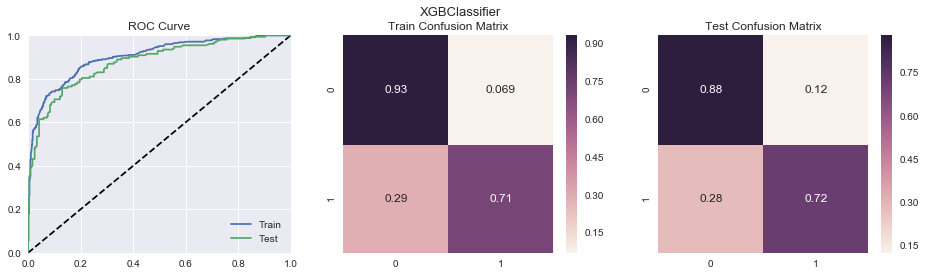

Permutation Importance:


Weight,Feature
0.1816 ± 0.0602,sex_enc
0.0653 ± 0.0271,pclass
0.0332 ± 0.0174,age
0.0112 ± 0.0083,sibsp
0.0107 ± 0.0131,embarked_enc
0.0036 ± 0.0263,fare
0.0005 ± 0.0075,parch


The mean XGBClassifier AUC for the model is 0.86.


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.8, learning_rate=0.20000000000000001, max_delta_step=0,
       max_depth=2, min_child_weight=2, missing=None, n_estimators=120,
       nthread=-1, objective='binary:logistic', reg_alpha=0.5,
       reg_lambda=1, scale_pos_weight=1.0, seed=0, silent=True,
       subsample=0.7)

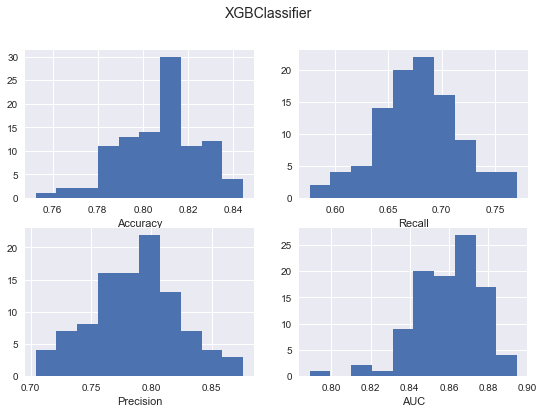

In [18]:
model3seeds(XGBClassifier(**rsearch.best_params_), 
            X, y, 'XGBClassifier')

different_models(XGBClassifier(**rsearch.best_params_), 
                 X, y, 'XGBClassifier', xgboost=True)

### Conclusions

While the training dataset still has a higher AUC than the test dataset, the gap is much smaller and therefore the model generalises better than before.

The features with the biggest influence on the roc_auc tuned models are: 
* sex (sanity check: women were saved first)
* age (sanity check: children were saved first)
* fare/pclass (sanity check: upper classes/higher fares were far more likely to survive due to the location of their cabins).

In [19]:
print("Completed running the Notebook at:", datetime.now())

Completed running the Notebook at: 2018-05-05 23:48:58.827285
